In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt

import collections
import re, string
import sys
import time
from nltk.corpus import stopwords
from wordcloud import WordCloud
import seaborn as sns

from subprocess import check_output
%matplotlib inline

## Importing the Data 

In [2]:
import json

def init_ds(json):
    ds= {}
    keys = json.keys()
    for k in keys:
        ds[k]= []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file, encoding='utf8') as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count ==0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
                
        return pd.DataFrame(dataset)

In [3]:
yelp_business= read_json('business.json')

In [4]:
yelp_review= read_json('review.json')

In [5]:
yelp_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685900 entries, 0 to 6685899
Data columns (total 9 columns):
review_id      object
user_id        object
business_id    object
stars          float64
useful         int64
funny          int64
cool           int64
text           object
date           object
dtypes: float64(1), int64(3), object(5)
memory usage: 459.1+ MB


In [6]:
yelp_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
business_id     192609 non-null object
name            192609 non-null object
address         192609 non-null object
city            192609 non-null object
state           192609 non-null object
postal_code     192609 non-null object
latitude        192609 non-null float64
longitude       192609 non-null float64
stars           192609 non-null float64
review_count    192609 non-null int64
is_open         192609 non-null int64
attributes      163773 non-null object
categories      192127 non-null object
hours           147779 non-null object
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


In [7]:
yelp_business.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [8]:
yelp_review.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


## Merge Data to Filter Review Data

#### Change the stars columns in Business Data to Restaurant Ratings, because it

In [9]:
yelp_business = yelp_business.rename(columns={'stars':'restaurant_ratings'})

#### Choose columns in business data and merge to review data

In [10]:
yelp_data = pd.merge(yelp_review,yelp_business[['business_id', 'name', 'city', 'state', 'restaurant_ratings', 'categories']], how='left', on='business_id')

## Filter Data only Restaurant Categories

In [11]:
yelp_data.shape

(6685900, 14)

In [12]:
yelp_data.isna().sum()

review_id                0
user_id                  0
business_id              0
stars                    0
useful                   0
funny                    0
cool                     0
text                     0
date                     0
name                     0
city                     0
state                    0
restaurant_ratings       0
categories            2137
dtype: int64

In [13]:
yelp_data.dropna(inplace=True)

In [14]:
yelp_data = yelp_data[yelp_data['categories'].str.contains("Food|Coffee|Tea|Restaurants|Bakeries|Bars|Sports Bar|Pubs|Nighlife")]

In [15]:
yelp_data.shape

(4699711, 14)

## Check median of User Count and Restaurant Count

In [16]:
count_rest_review = pd.DataFrame(yelp_data['business_id'].value_counts()).reset_index().rename(columns={'index':'business_id', 'business_id':'count_business'})

In [17]:
count_user_review = pd.DataFrame(yelp_data['user_id'].value_counts()).reset_index().rename(columns={'index':'user_id', 'user_id':'count_user'})

In [18]:
yelp_data = pd.merge(yelp_data, count_rest_review, how='left', on='business_id')

In [19]:
yelp_data = pd.merge(yelp_data, count_user_review, how='left', on='user_id')

In [21]:
yelp_data['count_user'].median()

10.0

In [22]:
yelp_data['count_business'].median()

199.0

In [20]:
yelp_data.shape

(4699711, 16)

## Filter data only in Arizona

In [23]:
yelp_data = yelp_data[yelp_data['state']=='AZ']

In [24]:
yelp_data.shape

(1318827, 16)

In [29]:
# yelp_data.to_csv('yelp_data_arizona_state_restaurant_original.csv', index=False)

## Filter data only in top 5 cities of Arizona State

In [40]:
yelp_data_top_city = yelp_data[(yelp_data['city']=='Phoenix')|
          (yelp_data['city']=='Scottsdale')|
          (yelp_data['city']=='Tempe')|
          (yelp_data['city']=='Mesa')|
          (yelp_data['city']=='Chandler')]

In [41]:
yelp_data_top_city.shape

(1051588, 16)

In [43]:
# yelp_data_top_city.to_csv('yelp_data_arizona_state_topcity_restaurant_original.csv', index=False)

(-1.1296001144193493,
 1.1014095292580643,
 -1.102083697235887,
 1.1265853925003078)

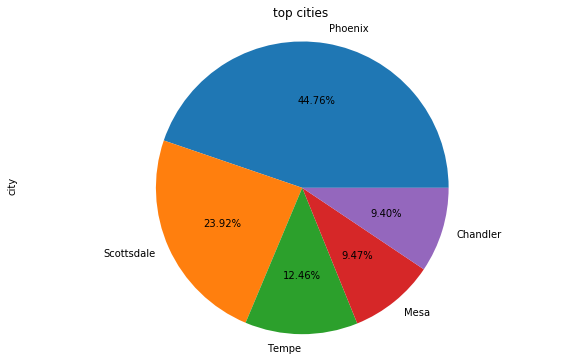

In [42]:
yelp_data_top_city['city'].value_counts().sort_values(ascending=False).plot(kind='pie',figsize=(10,6), 
title="top cities", autopct='%1.2f%%')
plt.axis('equal')

In [102]:
yelp_data_top_city.shape

(1051588, 16)

In [103]:
yelp_data_top_city = yelp_data_top_city.drop('count_business',axis=1)

In [104]:
yelp_data_top_city = yelp_data_top_city.drop('count_user',axis=1)

In [105]:
count_rest_review = pd.DataFrame(yelp_data_top_city['business_id'].value_counts()).reset_index().rename(columns={'index':'business_id', 'business_id':'count_business'})

In [106]:
count_user_review = pd.DataFrame(yelp_data_top_city['user_id'].value_counts()).reset_index().rename(columns={'index':'user_id', 'user_id':'count_user'})

In [107]:
yelp_data_top_city = pd.merge(yelp_data_top_city, count_rest_review, how='left', on='business_id')

In [108]:
yelp_data_top_city = pd.merge(yelp_data_top_city, count_user_review, how='left', on='user_id')

In [109]:
yelp_data_top_city['count_user'].describe()

count    1.051588e+06
mean     3.961807e+01
std      1.010888e+02
min      1.000000e+00
25%      3.000000e+00
50%      8.000000e+00
75%      3.100000e+01
max      1.316000e+03
Name: count_user, dtype: float64

In [110]:
yelp_data_top_city['count_business'].describe()

count    1.051588e+06
mean     3.914561e+02
std      4.310956e+02
min      3.000000e+00
25%      1.100000e+02
50%      2.460000e+02
75%      5.050000e+02
max      2.662000e+03
Name: count_business, dtype: float64

## Filter user review count more than yelp's median = 10 and Filter business review count more than yelp's median = 199

In [111]:
yelp_data_top_city = yelp_data_top_city[yelp_data_top_city['count_user']>10]

In [113]:
yelp_data_top_city = yelp_data_top_city[yelp_data_top_city['count_business']>199]

In [116]:
# yelp_data_top_city.to_csv('yelp_data_arizona_state_topcity_restaurant_filtermed_original.csv', index=False)

(-1.1091960633581242,
 1.100437912196039,
 -1.109289457939138,
 1.1192871116412468)

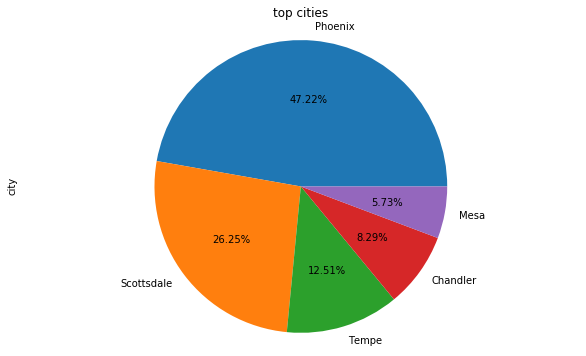

In [115]:
yelp_data_top_city['city'].value_counts().sort_values(ascending=False).plot(kind='pie',figsize=(10,6), 
title="top cities", autopct='%1.2f%%')
plt.axis('equal')

In [117]:
yelp_data_top_city.shape

(266059, 16)

## Sampling 10% Data 

In [118]:
# The data to load
f = 'yelp_data_arizona_state_topcity_restaurant_filtermed_original.csv'

# Take every N-th (in this case 100th) row
n = 10

# Count the lines or use an upper bound
num_lines = 266059

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = [x for x in range(1, num_lines) if x % n != 0]

# Read the data
yelp_chunk = pd.read_csv(f, skiprows=skip_idx)
yelp_chunk.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,city,state,restaurant_ratings,categories,count_business,count_user
0,V93SYj2OLh5m9Cquzf-7kg,ZwVz20be-hOZnyAbevyMyQ,2c9Vptks_vowLgVUMnCgjw,4.0,0,0,0,Came here while in town for a country concert....,2013-09-04 01:29:46,Dierks Bentley's Whiskey Row,Scottsdale,AZ,3.5,"American (Traditional), Breakfast & Brunch, Fo...",466,11
1,vNTFadc6T9HeH3Qa78dc_Q,91TB-gzcNyxFh46TL0pmnQ,6nKR80xEGHYf2UxAe_Cu_g,5.0,0,0,0,Best barbecue this side of the Mississippi!!!!...,2015-12-05 02:50:10,The Thumb BBQ,Scottsdale,AZ,4.5,"Farmers Market, Gas Stations, Automotive, Car ...",991,135
2,SXRFBCt5eXCBF7TlI7UG6Q,Y_QBiZpATJoz8hKUfYF66A,fbQaKW0Lte0JQ_opbnjdKg,5.0,1,0,0,Absolutely amazing. Think Chipotle for enchila...,2014-04-01 01:56:00,Gadzooks Enchiladas & Soup,Phoenix,AZ,4.0,"Restaurants, Specialty Food, Food, Soup, Break...",834,36
3,CqMNjtG0hNZGhDw4RDE-zw,_Jg-IA0M-GSjBlGu-wmejg,r8764MtYyt8JhxMvrfM_xQ,2.0,0,0,0,I was really disappointed with my most recent ...,2014-10-11 03:53:53,Vintage 95,Chandler,AZ,4.0,"American (New), Bars, Wine Bars, Nightlife, Re...",329,15
4,5hZLouGEW4wm6BTJ5aNUNw,1CqkFliipv_X15WYn5aPfg,QS3QxI7u5PRdtbGgI0-UsA,4.0,0,0,0,I grade sushi restaurants on 3 factors:\n- Qua...,2015-03-04 19:36:21,Sakana Sushi & Grill,Scottsdale,AZ,4.0,"Asian Fusion, Restaurants, Seafood, Sushi Bars...",365,33


In [119]:
yelp_chunk.shape

(26606, 16)

(-1.1095937573563732,
 1.1004568455883987,
 -1.1074504852545537,
 1.119468998057295)

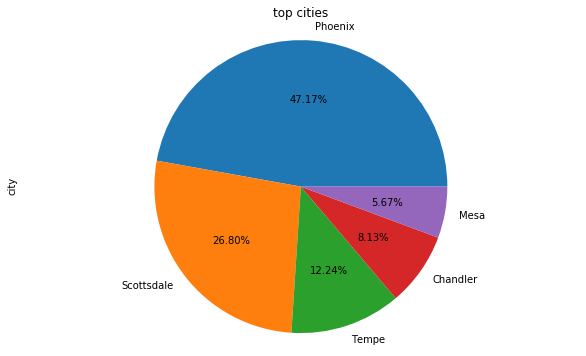

In [120]:
yelp_chunk['city'].value_counts().sort_values(ascending=False).head(10).plot(kind='pie',figsize=(10,6), 
title="top cities", autopct='%1.2f%%')
plt.axis('equal')

## Export Data

In [121]:
yelp_chunk.to_csv('yelp_data_arizona_state_topcity_restaurant_sampling_FINAL_DATA.csv', index=False)

## Export Data

In [26]:
# yelp_data_arizona.to_csv('yelp_arizona_data.csv', index=False)

In [5]:
# yelp_business.to_csv('yelp_business.csv', index=False)

In [6]:
# yelp_review.to_csv('yelp_review.csv', index=False)